# Surface Waves Analysis - Notebook 0
This routine demonstrates a complete workflow for surface wave analysis, from the synthetic modeling with `disba`to inversion with `evodcinv`.  The example is taken from <https://www.geopsy.org/wiki/index.php/Dispersion_curve_inversion>

**Author:** Alberto Carrera

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SWAutils as swa

from matplotlib.ticker import ScalarFormatter
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from disba import PhaseDispersion, depthplot
from evodcinv import EarthModel, Layer, Curve

## 1. Synthetic Layered Model Construction

We construct a synthetic layered velocity model starting from **layer thickness** and **P-wave velocity** $V_p$, and assume a constant **Poisson’s ratio** $\mu$ for all layers.  From these parameters, we calculate the **S-wave velocity** $V_s$ and the **density** $\rho$ through elastic relations.


For an isotropic, elastic material, the relationship between $V_p$, $V_s$, and $\mu$ is:
$$
V_s = \frac{V_p}{\sqrt{\frac{2(1-\mu)}{1-2\mu}}}
$$

Using the elastic wave equations:

$$
V_p = \sqrt{\frac{K + \frac{4}{3}G}{\rho}}, \quad
V_s = \sqrt{\frac{G}{\rho}}
$$

and expressing the bulk modulus $K$ in terms of the shear modulus $G$ and Poisson’s ratio $\mu$:

$$
K = \frac{2G(1+\mu)}{3(1-2\mu)}
$$

we can derive a direct formula for the density:

$$
\rho = \frac{V_p^2 (1 - 2\mu)}{2 V_s^2 (1 - \mu)}
$$

This allows us to compute $\rho$ automatically from the velocities and Poisson’s ratio.

In [2]:
# Basic model parameters: [thickness (m), Vp (m/s)]
layers = np.array([
    [7.5,  500.0],    # layer 1
    [25.0, 1350.0],   # layer 2
    [0.0,  2000.0],   # half-space
])

nu = 0.35 # Poisson's ratio (fixed)

# Retrieve Vs and density
vp = layers[:, 1]
thickness = layers[:, 0]

vs = vp / np.sqrt(2 * (1 - nu) / (1 - 2*nu))
rho = (vp**2 * (1 - 2*nu)) / (2 * vs**2 * (1 - nu))

Now we can assemble the **velocity model** as a NumPy array with columns:

$$
[\text{thickness (m)}, V_p \text{ (m/s)}, V_s \text{ (m/s)}, \rho \text{ (kg/m³)}]
$$

In [3]:
velocity_model = np.column_stack([thickness, vp, vs, rho])

np.set_printoptions(precision=1)
print("velocity_model [thickness, Vp, Vs, rho]:\n", velocity_model)

velocity_model [thickness, Vp, Vs, rho]:
 [[7.5e+00 5.0e+02 2.4e+02 1.0e+00]
 [2.5e+01 1.4e+03 6.5e+02 1.0e+00]
 [0.0e+00 2.0e+03 9.6e+02 1.0e+00]]


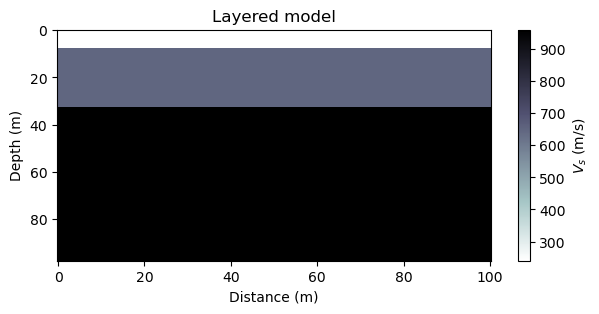

In [4]:
# plot the model
fig, ax = plt.subplots(figsize=(7, 3))
swa.plot_synthmodel(velocity_model, ax=ax)
plt.show()

## 2. Synthetic Rayleigh wave dispersion curves

Using `PhaseDispersion` from `disba`, phase velocities are calculated for the fundamental mode (mode 0) and the first three higher modes (modes 1–3) over a range of frequencies. The resulting curves show **phase velocity vs. frequency** for each mode, illustrating the dispersion behavior of surface waves.


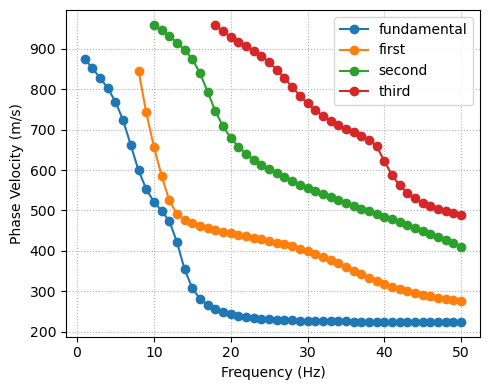

In [5]:
pd = PhaseDispersion(*velocity_model.T)
f = np.linspace(1.0, 50.0, 50) # frequencies
t = 1.0 / f[::-1] # periods
dc_0 = pd(t, mode=0, wave="rayleigh")
dc_1 = pd(t, mode=1, wave="rayleigh")
dc_2 = pd(t, mode=2, wave="rayleigh")
dc_3 = pd(t, mode=3, wave="rayleigh")

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(1/dc_0.period, dc_0.velocity, "-o", label='fundamental')
ax.plot(1/dc_1.period, dc_1.velocity, "-o", label='first')
ax.plot(1/dc_2.period, dc_2.velocity, "-o", label='second')
ax.plot(1/dc_3.period, dc_3.velocity, "-o", label='third')
ax.set_ylabel('Phase Velocity (m/s)')
ax.set_xlabel('Frequency (Hz)')
ax.grid(linestyle=':')
ax.legend()
fig.tight_layout()

## 3. Inversion modeling

We initialize an `Earth model` for inversion and build the layered Earth initial model from top to bottom, with search boundaries
- `thickness[m]`  ---> [thick min, thick max]
- ` S-wave velocity[m/s]` ---> [vel min, vel max]


In [6]:
# Initialize model
model = EarthModel()

# Build model 
for _ in range(5):
    model.add(Layer([1, 10], [100, 1000]))
model

--------------------------------------------------------------------------------
Earth model parameters

------------------------------------------------------------
              d [km]           vs [km/s]              nu [-]
       min       max       min       max       min       max
------------------------------------------------------------
    1.0000   10.0000  100.0000 1000.0000    0.2000    0.4000
    1.0000   10.0000  100.0000 1000.0000    0.2000    0.4000
    1.0000   10.0000  100.0000 1000.0000    0.2000    0.4000
    1.0000   10.0000  100.0000 1000.0000    0.2000    0.4000
    1.0000   10.0000  100.0000 1000.0000    0.2000    0.4000
------------------------------------------------------------

Number of layers: 5
Number of parameters: 15
--------------------------------------------------------------------------------

then we define a `density_from_vp` function based on **P-wave velocity** using the empirical relation (Gardner et al., 1974):

$$
\rho = 0.31 \, V_p^{0.25}
$$

$V_p$ in m/s, $rho$ in g/cm³. This provides a simple way to estimate density from seismic velocity for use in inversion, if we have no other extra information.

In [7]:
# density function from Gardner et al. (1974) Formation velocity and density – the diagnostic basics for stratigraphic traps. Geophysics, 39(6), 770–780. https://doi.org/10.1190/1.1440465
density_from_vp=  lambda vp: 0.31 * (vp)**0.25

### 3.1 Optimization parameters
Here we define inversion settings required from `evodcinv` (Luu, 2023 - <https://doi.org/10.5281/zenodo.10112876>) to perturbate the layer parameters within the optimization procedure. We can use the fundamental Rayleigh mode (mode 0) only, ora add the upper armonics.


In [9]:
# Configure model
model.configure(
    optimizer="cpso",
    misfit="rmse",
    density=density_from_vp,
    optimizer_args={
        "popsize": 20,
        "maxiter": 100,
        "workers": -1,
        "seed": 0,
    },
    increasing_velocity=True, # optional
)

# Define dispersion curves to invert
curves = [Curve(dc_0.period, dc_0.velocity, 0, "rayleigh", "phase"), # fundamental
          Curve(dc_1.period, dc_1.velocity, 1, "rayleigh", "phase"), # first
         ]
curves

[--------------------------------------------------------------------------------
 Rayleigh-wave phase velocity
 
 Number of data points: 50
 Period bounds: [0.0200, 1.0000] s
 Mode: 0
 --------------------------------------------------------------------------------,
 --------------------------------------------------------------------------------
 Rayleigh-wave phase velocity
 
 Number of data points: 43
 Period bounds: [0.0200, 0.1250] s
 Mode: 1
 --------------------------------------------------------------------------------]

### 3.2 Run Inversion and save the results
See stochopy's documentation for optimizer options <https://keurfonluu.github.io/stochopy/>

In [10]:
res = model.invert(curves, maxrun=3)

res = res.threshold(5 * np.min(res.misfits))
res

Run 1  |████████████████████| 100% [0:32:56 / 0:00:00] - Misfit: 8.6186  
Run 2  |████████████████████| 100% [0:29:15 / 0:00:00] - Misfit: 1.6872  
Run 3  |████████████████████| 100% [0:25:07 / 0:00:00] - Misfit: 14.7362 


--------------------------------------------------------------------------------
Best model out of 343 models (3 runs)

Velocity model                                    Model parameters
----------------------------------------          ------------------------------
         d        vp        vs       rho                   d        vs        nu
      [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
----------------------------------------          ------------------------------
    7.6445  518.8514  241.0854    1.4795              7.6445  241.0854    0.3623
    9.3523 1058.4926  608.5805    1.7682              9.3523  608.5805    0.2531
    9.1908 1392.6504  632.2790    1.8937              9.1908  632.2790    0.3702
    7.0286 1176.7165  675.3703    1.8156              7.0286  675.3703    0.2544
    1.0000 1781.0127  973.3066    2.0139                   -  973.3066    0.2871
----------------------------------------          ------------------------------

Nu

In [43]:
# save best model
filename = "synth_2mod"
figdir = '../figures/'
swa.save_model(res, filename)

📁 Model saved in: ../data/inv/synth_2mod


## 4. Plot results

/tmp/ipykernel_12324/93794277.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


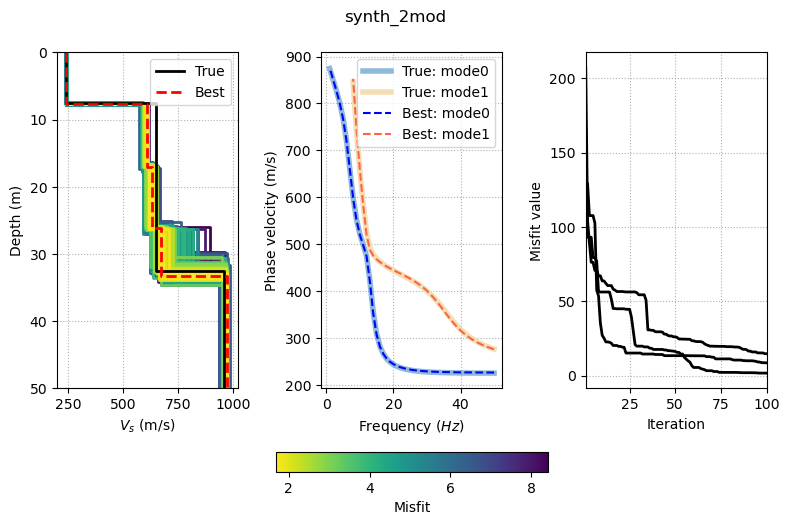

In [52]:
# Plot results
fig, ax = plt.subplots(1, 3, figsize=(8, 4.5))

zmax, cmap = 50, "viridis_r"

# 1. Velocity model
res.plot_model("vs", zmax=zmax, show="all", ax=ax[0], plot_args={"cmap": cmap})
depthplot(velocity_model[:, 0], velocity_model[:, 2], zmax=zmax, ax=ax[0],
          plot_args={"color": "black", "linewidth": 2, "label": "True"})
res.plot_model("vs", zmax=zmax, show="best", ax=ax[0],
               plot_args={"color": "red", "linestyle": "--", "label": "Best"})

# 2. Dispersion curve
#res.plot_curve(t, 0, "rayleigh", "phase", show="all", ax=ax[1], plot_args={"xaxis": "frequency", "cmap": cmap})
ax[1].plot(1.0 / dc_0.period, dc_0.velocity,
               color="tab:blue", linewidth=4, label="True: mode0", alpha=.5)
#res.plot_curve(t, 1, "rayleigh", "phase", show="all", ax=ax[1], plot_args={"xaxis": "frequency", "cmap": cmap})
ax[1].plot(1.0 / dc_1.period, dc_1.velocity,
               color="wheat", linewidth=4, label="True: mode1")

res.plot_curve(t, 0, "rayleigh", "phase", show="best", ax=ax[1],
               plot_args={"xaxis": "frequency", "color": "blue", "linestyle": "--", "label": "Best: mode0"})

res.plot_curve(t, 1, "rayleigh", "phase", show="best", ax=ax[1],
               plot_args={"xaxis": "frequency", "color": "tomato", "linestyle": "--", "label": "Best: mode1"})

# 3. Misfit
res.plot_misfit(ax=ax[2])

# Cosmetics
for a in ax: 
    a.grid(True, linestyle=":")
    
ax[0].legend(loc=1)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel(r'$V_s$ (m/s)')
#ax[1].set_xlim(2.0, 20.0)
ax[1].xaxis.set_major_formatter(ScalarFormatter())
ax[1].xaxis.set_minor_formatter(ScalarFormatter())
ax[1].legend(loc=1)
ax[1].set_ylabel('Phase velocity (m/s)')
ax[1].set_xlabel('Frequency $(Hz)$')

norm = Normalize(vmin=res.misfits.min(), vmax=res.misfits.max())
smap = ScalarMappable(norm=norm, cmap=cmap)
axins = inset_axes(ax[1], width="150%", height="6%", loc="lower center", borderpad=-6.0)
cb = plt.colorbar(smap, cax=axins, orientation="horizontal")
cb.set_label("Misfit")
fig.suptitle(filename)
plt.tight_layout()
plt.savefig(figdir+filename+'_model.png', dpi=200)
plt.show()

we can have a close look at period-velocity behaviour between true and predicted data.

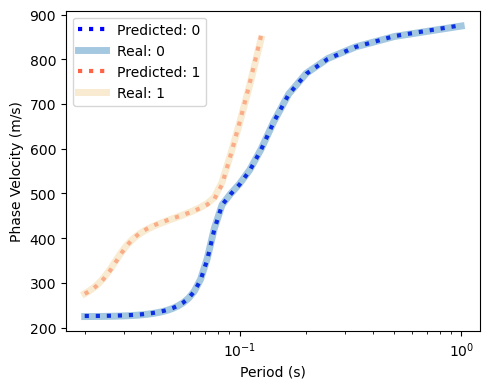

In [55]:
fig, ax = plt.subplots(figsize=(5, 4))

res.plot_curve(t, 0, "rayleigh", "phase", show="best", ax=ax, plot_args={"label": "Predicted: 0", "linestyle": "dotted", "linewidth": "3", "color": "blue"})
ax.semilogx(dc_0.period, dc_0.velocity, label='Real: 0',linewidth=5, alpha=.4, color='tab:blue')
res.plot_curve(t, 1, "rayleigh", "phase", show="best", ax=ax, plot_args={"label": "Predicted: 1", "linestyle": "dotted", "linewidth": "3", "color": "tomato"})
ax.semilogx(dc_1.period, dc_1.velocity, label='Real: 1',linewidth=5, alpha=.6, color='wheat')
ax.set_ylabel('Phase Velocity (m/s)')
ax.set_xlabel('Period (s)')
ax.legend()

fig.tight_layout()